In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/")

Mounted at /content/drive


In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
max_degree = 20
n_train,n_test = 100,100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train+n_test,1)) 
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # 计算features的0-3次方 返回的是[200,20]
for i in range(max_degree): # 0,1,2,3,0,0,...,0
    poly_features[:,i] /= math.gamma(i+1) # gamma(n) = (n-1)!  每一个项除以一个它的阶乘 
labels = np.dot(poly_features, true_w) # (200,)
labels += np.random.normal(scale=0.1, size=labels.shape) # 加上噪音

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.0236],
         [-0.3126]]),
 tensor([[ 1.0000e+00,  2.3580e-02,  2.7800e-04,  2.1851e-06,  1.2881e-08,
           6.0745e-11,  2.3873e-13,  8.0416e-16,  2.3702e-18,  6.2099e-21,
           1.4643e-23,  3.1388e-26,  6.1678e-29,  1.1187e-31,  1.8842e-34,
           2.9620e-37,  4.3652e-40,  6.0536e-43,  1.4013e-45,  0.0000e+00],
         [ 1.0000e+00, -3.1258e-01,  4.8853e-02, -5.0902e-03,  3.9777e-04,
          -2.4867e-05,  1.2955e-06, -5.7849e-08,  2.2603e-09, -7.8503e-11,
           2.4538e-12, -6.9729e-14,  1.8163e-15, -4.3673e-17,  9.7509e-19,
          -2.0320e-20,  3.9697e-22, -7.2991e-24,  1.2675e-25, -2.0853e-27]]),
 tensor([5.0561, 4.4576]))

In [5]:
def evaluate_loss(net,data_iter,loss):
  metric = d2l.Accumulator(2)
  for X,y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out,y)
    metric.add(l.sum(),l.numel())
  return metric[0]/metric[1]

In [8]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.989615   1.2087412 -3.3995018  5.5848413]]


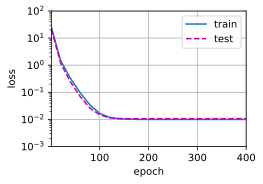

In [9]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.64659   4.2780457]]


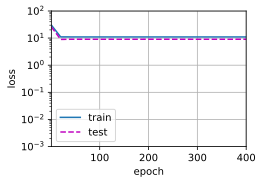

In [10]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.988949    1.3369647  -3.3560915   5.0209885  -0.22472206  1.1186455
   0.30397257  0.16069244  0.1137927   0.20726843 -0.02675069  0.01835873
  -0.15189296  0.12962687 -0.02483345 -0.16669908 -0.17243162  0.09601486
   0.04768945  0.17051874]]


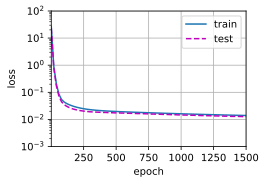

In [11]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)